<a href="https://colab.research.google.com/github/sungmin98/sungminai/blob/main/load_customLoad_csv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

from torch.autograd import Variable

from PIL import Image

In [16]:
#네트워크에 들어갈 이미지 크기
#ㄴ네트워크에는 동일한 크기의 이미지만 넣을 수 있음.
#ㄴGPU 병렬처리 때문
batch_size=2
imgsize=256

In [17]:
import os
import pandas as pd

"""
============================================
MyGetInfoFromCsv
============================================
*csv 파일 읽어서 클래스 및 데이터 정보 알아내기
*호출 방법
classes, class_to_idx, length, flist, labels=read_csv(i_csv_path, i_key_field)
*입력변수
 i_csv_path: .csv 파일 경로(파일)
 i_img_path: 실체 이미지들이 저장된 경로(폴더)
 i_key_field: 클래스로 삼을 필드
 ㄴ예) 'technique' or 'style' or 'artist_slug' or...

 *양희경 함수- read_csv
 """
def MyGetInfoFromCsv(i_csv_path, i_img_path, i_key_field='technique'):
     cwd=os.getcwd()
     with open(i_csv_path, encoding='windows-1252') as csfile:
       info = pd.read_csv(csfile)

       classes=sorted(set(info[i_key_field]))
       class_to_idx = {}
       total_file_list=[]
       total_label=[]

       for i, c in enumerate(classes): #모든 클래스에 대해
           class_to_idx.update({c: i})
       length = len(info) #모든 이미지 정보 개수

       for i in range(length): #모든 이미지에 대해
           key_val = info[i_key_field][i]
           total_file_list.append(i_img_path + info['image_id'][i]+".jpg")
           total_label.append(class_to_idx[key_val])
       return classes, class_to_idx, length, total_file_list, total_label

In [18]:
#MyGetInfoFromCsv 호출 테스트
csv_path="drive/MyDrive/wiki/"+"wikipaintings_oct2013_technique+test+15.csv"
img_path="drive/MyDrive/wiki/"+"images/"
classes, class_to_idx, length, flist, labels=MyGetInfoFromCsv(csv_path, img_path, "technique")

print(classes)
print(class_to_idx)
print(length)
print(flist[:3])
print(labels[:3])

['oil', 'pastel', 'pencil', 'watercolor']
{'oil': 0, 'pastel': 1, 'pencil': 2, 'watercolor': 3}
563
['drive/MyDrive/wiki/images/john-william-waterhouse_ophelia-1894.jpg', 'drive/MyDrive/wiki/images/yves-tanguy_death-awaiting-his-family-1927.jpg', 'drive/MyDrive/wiki/images/john-french-sloan_stein-profile-foreign-girl-1905.jpg']
[0, 0, 0]


In [23]:
"""
===============================================
MyImageCSV
===============================================
# *.csv 파일로 읽은 영상을 자동으로 잘라주기
# * 입력 변수
#   i_csv_path: .csv 파일 경로(파일)
    i_img_path: 실체 이미지들이 저장된 경로(폴더)
    i_key_field: 클래스로 삼을 필드
    ㄴ예) 'technique' or 'style' or 'artist_slug' or...
  i_imgsize: 기준이 되는 imgsize
  ㄴ주의: rescale의 최대 배수의 사이즈가 네트워크가 안터지는 최대 사이즈 이하여야 함.
  i_DataAug: data augmentation 연산 추가 여부. 보통 train용 데이터에 사용됨.

*양희경 클래스- Dataset_csv
"""
class MyImageCSV(Dataset):
    def __init__(self, i_csv_path, i_img_path, i_key_field,
               i_imgsize=128,
               i_DataAug=False, transform=transforms.ToTensor()):
      self.classes, self.class_to_idx, self.length, self.flist, self.labels=MyGetInfoFromCsv(i_csv_path, i_img_path, i_key_field)
      self.imgsize=i_imgsize
      self.i_DataAug=i_DataAug
      self.transform=transform

    def __len__(self):
          return self.length #이 path에 있는 모든 폴더의 모든 이미지 개수

    def __getitem__(self, idx):
        max_size = self.imgsize

        #1. original image
        img=Image.open(self.flist[idx])

        #2. 예외처리-mode
        if (img.mode!="RGB"):
            img=img.conver(mode="RGB")

        #이미지 조정
        img=self.transform(img)

        #label
        label=self.labels[idx]

        return img, label

In [24]:
#MyImageFolder 호출 테스트
csv_path="drive/MyDrive/wiki/"+"wikipaintings_oct2013_technique+test+15.csv"
img_path="drive/MyDrive/wiki/"+"images/"

my_test = MyImageCSV(csv_path, img_path, 'technique',
                   i_imgsize=imgsize, i_DataAug=True)

nclass = len(my_test.classes)
print("# of classs(클래스 개수): %d" %nclass)

print("클래이 이름:", my_test.classes)
print("클래스별 인덱스:", my_test.class_to_idx)
print("my_train 개수:", my_test. __len__())

# of classs(클래스 개수): 4
클래이 이름: ['oil', 'pastel', 'pencil', 'watercolor']
클래스별 인덱스: {'oil': 0, 'pastel': 1, 'pencil': 2, 'watercolor': 3}
my_train 개수: 563


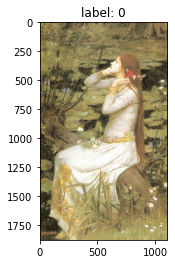

torch.Size([1879, 1100, 3])


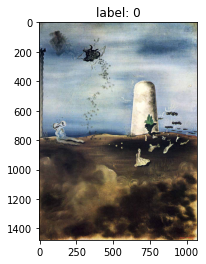

torch.Size([1478, 1069, 3])


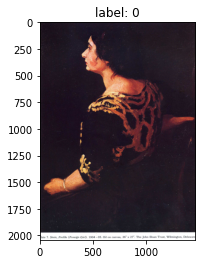

torch.Size([2042, 1462, 3])


In [25]:
for i in range(3):
  img = my_test[i][0] #numpy() #image 타입을 numpy로 변환 (3, width, height)
  img = np. transpose(img, (1, 2, 0)) # (3, width, height) -> (width, height, 3)

  plt.title("label: %d" %my_test[i][1] )
  plt.imshow(img)
  plt.show()

  print(img.shape)    #print(img.size)

In [29]:
my_test = MyImageCSV(csv_path, img_path, 'technique',
                     i_imgsize=imgsize,
                     i_DataAug=True,
                     transform=transforms.Compose([transforms.Resize((imgsize, imgsize)),
                                                   transforms.ToTensor()])
                     )
my_loader = DataLoader(my_test, batch_size=batch_size,
                       shuffle=False, num_workers = 2)

[0]
한 번에 로드되는 데이터 크기: 2
torch.Size([2, 3, 256, 256])
torch.Size([2])


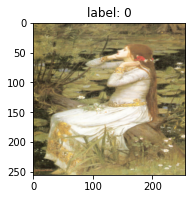

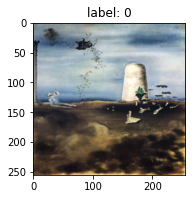

[1]
한 번에 로드되는 데이터 크기: 2
torch.Size([2, 3, 256, 256])
torch.Size([2])


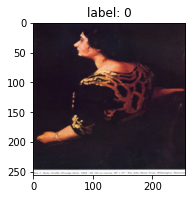

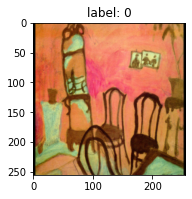

In [33]:
n = 2 #샘플로 그려볼 데이터 개수
for i, [imgs, labels] in enumerate(my_loader):  #batch_size 만큼
    if i>1:
       break

    print ("[%d]" %i)
    print ("한 번에 로드되는 데이터 크기:", len(imgs))

     # GPU에 로드되기 위함. 만약 CPU로 설정되어 있다면 자동으로(?) CPU로 로드됨
    x = Variable(imgs)#.cuda()  # (batch_size, 3, 28, 28)
    y_ = Variable(labels)#.cuda()  # (batch_size)

    print(x.shape)
    print(y_.shape)

    #그리기
    for j in range(n):
        img = imgs[j].numpy()  # image 타입을 numpy로 변환 (3, width, height)
        img = np.transpose(img, (1, 2, 0)) # (3, width, height) -> (width, height, 3)

        plt.subplot(1, n, j+1)  # (1,3) 형태 플랏의 j번째 자리에 그리겠다
        plt.imshow(img)  #, cmap='gray')
        plt.title("label: %d" %labels[j] )
        plt.show()